In [1]:
# this is an example of federated leraning for voice data
# I borrowed almost all codes from this repositry. Thank a lot!
# https://github.com/tugstugi/pytorch-speech-commands.git

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# First let's run some code for jupyter notebooks
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# import dependencies.
import torch
from torchvision.transforms import Compose
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import math
import time
from tqdm import *
import os
import librosa
import numpy as np
import random
# from torch.autograd import Variable

In [5]:
# CLASSES = 'unknown, silence, yes, no, up, down, left, right, on, off, stop, go'.split(', ')
CLASSES = 'unknown, silence, yes, no, left, right'.split(', ')

In [6]:
# prepare datasets

In [7]:
# prepare datasets

# create directory it not exist
# we put data on datasets directory
if os.path.isdir('./datasets') is False:
    try:
        os.mkdir('./datasets')
    except OSError:
        print ("Creation of the directory datasets failed")

# download data
# ! wget -O datasets/speech_commands_v0.01.tar.gz http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

# prepare directories
if os.path.isdir('./datasets/speech_commands') is False:
    try:
        os.mkdir('./datasets/speech_commands')
    except OSError:
        print ("Creation of the directory datasets/speech_commands failed")
        
if os.path.isdir('./datasets/speech_commands/audio') is False:
    try:
        os.mkdir('./datasets/speech_commands/audio')
    except OSError:
        print ("Creation of the directory datasets/speech_commands/audio failed")
        

# untar files.
# ! tar -xzf datasets/speech_commands_v0.01.tar.gz -C datasets/speech_command/audio
        

In [8]:
# once you downloaded datasets,
# you can split datasets into train and valid.
# since which one is for validation is defined by txt file, just split data accordingly.

# mode files 
def move_files(src_folder, to_folder, list_file):
    with open(list_file) as f:
        for line in f.readlines():
            line = line.rstrip()
            dirname = os.path.dirname(line)
            dest = os.path.join(to_folder, dirname)
            if not os.path.exists(dest):
                os.mkdir(dest)
            shutil.move(os.path.join(src_folder, line), dest)

In [9]:
# move files
def prepare_dataset():
    audio_folder = "datasets/speech_commands/audio"
    validation_path = "datasets/speech_commands/audio/validation_list.txt"
    test_path = "datasets/speech_commands/audio/testing_list.txt"

    valid_folder = "datasets/speech_commands/valid"
    test_folder = "datasets/speech_commands/test"
    train_folder = "datasets/speech_commands/train"

    if os.path.isdir(valid_folder) is False:
        os.mkdir(valid_folder)
    if os.path.isdir(test_folder) is False:
        os.mkdir(test_folder)

    move_files(audio_folder, test_folder, test_path)
    move_files(audio_folder, valid_folder, validation_path)
    os.rename(audio_folder, train_folder)

In [10]:
# import shutil for moving files.
# impo rt shutil

# run prepare datasets
# prepare_dataset()


In [11]:
! ls datasets

speech_commands  speech_commands_v0.01.tar.gz


In [12]:
# here we define convenient functions for audio.
# most of them is for data augmentation

In [13]:
# this is just returning true or false ramdomly
def should_apply_transform(prob=0.5):
    """Transforms are only randomly applied with the given probability."""
    return random.random() < prob

In [14]:
# change ampletude for data augmentation
class ChangeAmplitude(object):
    """Changes amplitude of an audio randomly."""

    def __init__(self, amplitude_range=(0.7, 1.1)):
        self.amplitude_range = amplitude_range

    def __call__(self, data):
        if not should_apply_transform():
            return data

        data['samples'] = data['samples'] * random.uniform(*self.amplitude_range)
        return data

In [15]:
# change speedch and pitch for data augmentation
class ChangeSpeedAndPitchAudio(object):
    """Change the speed of an audio. This transform also changes the pitch of the audio."""

    def __init__(self, max_scale=0.2):
        self.max_scale = max_scale

    def __call__(self, data):
        if not should_apply_transform():
            return data

        samples = data['samples']
        sample_rate = data['sample_rate']
        scale = random.uniform(-self.max_scale, self.max_scale)
        speed_fac = 1.0  / (1 + scale)
        data['samples'] = np.interp(np.arange(0, len(samples), speed_fac), np.arange(0,len(samples)), samples).astype(np.float32)
        return data

In [16]:
# function to fix audio length 
# Because our architecture is not RNN-based but CNN-based, we need shapes of all input data exact same.
class FixAudioLength(object):
    """Either pads or truncates an audio into a fixed length."""

    def __init__(self, time=1):
        self.time = time

    def __call__(self, data):
        samples = data['samples']
        sample_rate = data['sample_rate']
        length = int(self.time * sample_rate)
        if length < len(samples):
            data['samples'] = samples[:length]
        elif length > len(samples):
            data['samples'] = np.pad(samples, (0, length - len(samples)), "constant")
        return data

In [17]:

class ToSTFT(object):
    """Applies on an audio the short time fourier transform."""

    def __init__(self, n_fft=2048, hop_length=512):
        self.n_fft = n_fft
        self.hop_length = hop_length

    def __call__(self, data):
        samples = data['samples']
        sample_rate = data['sample_rate']
        data['n_fft'] = self.n_fft
        data['hop_length'] = self.hop_length
        data['stft'] = librosa.stft(samples, n_fft=self.n_fft, hop_length=self.hop_length)
        data['stft_shape'] = data['stft'].shape
        return data

In [18]:
class StretchAudioOnSTFT(object):
    """Stretches an audio on the frequency domain."""

    def __init__(self, max_scale=0.2):
        self.max_scale = max_scale

    def __call__(self, data):
        if not should_apply_transform():
            return data

        stft = data['stft']
        sample_rate = data['sample_rate']
        hop_length = data['hop_length']
        scale = random.uniform(-self.max_scale, self.max_scale)
        stft_stretch = librosa.core.phase_vocoder(stft, 1+scale, hop_length=hop_length)
        data['stft'] = stft_stretch
        return data

In [19]:
class TimeshiftAudioOnSTFT(object):
    """A simple timeshift on the frequency domain without multiplying with exp."""

    def __init__(self, max_shift=8):
        self.max_shift = max_shift

    def __call__(self, data):
        if not should_apply_transform():
            return data

        stft = data['stft']
        shift = random.randint(-self.max_shift, self.max_shift)
        a = -min(0, shift)
        b = max(0, shift)
        stft = np.pad(stft, ((0, 0), (a, b)), "constant")
        if a == 0:
            stft = stft[:,b:]
        else:
            stft = stft[:,0:-a]
        data['stft'] = stft
        return data

In [20]:
class FixSTFTDimension(object):
    """Either pads or truncates in the time axis on the frequency domain, applied after stretching, time shifting etc."""

    def __call__(self, data):
        stft = data['stft']
        t_len = stft.shape[1]
        orig_t_len = data['stft_shape'][1]
        if t_len > orig_t_len:
            stft = stft[:,0:orig_t_len]
        elif t_len < orig_t_len:
            stft = np.pad(stft, ((0, 0), (0, orig_t_len-t_len)), "constant")

        data['stft'] = stft
        return data


In [21]:
# data augmentation
data_aug_transform = Compose([
    ChangeAmplitude(), 
    ChangeSpeedAndPitchAudio(), 
    FixAudioLength(), 
    ToSTFT(), 
    StretchAudioOnSTFT(), 
    TimeshiftAudioOnSTFT(), 
    FixSTFTDimension()])


In [22]:
class BackgroundNoiseDataset(Dataset):
    """Dataset for silence / background noise."""

    def __init__(self, folder, transform=None, sample_rate=16000, sample_length=1):
        audio_files = [d for d in os.listdir(folder) if os.path.isfile(os.path.join(folder, d)) and d.endswith('.wav')]
        samples = []
        for f in audio_files:
            path = os.path.join(folder, f)
            s, sr = librosa.load(path, sample_rate)
            samples.append(s)

        samples = np.hstack(samples)
        c = int(sample_rate * sample_length)
        r = len(samples) // c
        self.samples = samples[:r*c].reshape(-1, c)
        self.sample_rate = sample_rate
        self.classes = CLASSES
        self.transform = transform
        self.path = folder

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        data = {'samples': self.samples[index], 'sample_rate': self.sample_rate, 'target': 1, 'path': self.path}
        
        if self.transform is not None:
            data = self.transform(data)

        return data

In [23]:
# define background nosie datasets

# background_noise_dir = "./datasets/speech_commands/train/_background_noise_"
background_noise_dir = "/disk2/ohashi/pytorch-speech-commands/datasets/speech_commands/train/_background_noise_"

bg_dataset = BackgroundNoiseDataset(background_noise_dir, data_aug_transform)


In [24]:
# function to add background noise on datasets

class AddBackgroundNoiseOnSTFT(Dataset):
    """Adds a random background noise on the frequency domain."""

    def __init__(self, bg_dataset, max_percentage=0.45):
        self.bg_dataset = bg_dataset
        self.max_percentage = max_percentage

    def __call__(self, data):
        if not should_apply_transform():
            return data

        noise = random.choice(self.bg_dataset)['stft']
        percentage = random.uniform(0, self.max_percentage)
        data['stft'] = data['stft'] * (1 - percentage) + noise * percentage
        return data

In [25]:
# create a function
add_bg_noise = AddBackgroundNoiseOnSTFT(bg_dataset)

In [26]:
# function to convert data from STFT into MelSpectrogram

class ToMelSpectrogramFromSTFT(object):
    """Creates the mel spectrogram from the short time fourier transform of a file. The result is a 32x32 matrix."""

    def __init__(self, n_mels=32):
        self.n_mels = n_mels

    def __call__(self, data):
        stft = data['stft']
        sample_rate = data['sample_rate']
        n_fft = data['n_fft']
        mel_basis = librosa.filters.mel(sample_rate, n_fft, self.n_mels)
        s = np.dot(mel_basis, np.abs(stft)**2.0)
        data['mel_spectrogram'] = librosa.power_to_db(s, ref=np.max)
        return data

In [27]:
class DeleteSTFT(object):
    """Pytorch doesn't like complex numbers, use this transform to remove STFT after computing the mel spectrogram."""

    def __call__(self, data):
        del data['stft']
        return data

In [28]:
class ToTensor(object):
    """Converts into a tensor."""

    def __init__(self, np_name, tensor_name, normalize=None):
        self.np_name = np_name
        self.tensor_name = tensor_name
        self.normalize = normalize

    def __call__(self, data):
        tensor = torch.FloatTensor(data[self.np_name])
        if self.normalize is not None:
            mean, std = self.normalize
            tensor -= mean
            tensor /= std
        data[self.tensor_name] = tensor
        return data

In [29]:
# define data preprocessing more

n_mels = 32

train_feature_transform = Compose([
    ToMelSpectrogramFromSTFT(n_mels=n_mels), 
    DeleteSTFT(), 
    ToTensor('mel_spectrogram', 'input')])


In [30]:
class LoadAudio(object):
    """Loads an audio into a numpy array."""

    def __init__(self, sample_rate=16000):
        self.sample_rate = sample_rate

    def __call__(self, data):
        
        path = data['path']
        if path:
            samples, sample_rate = librosa.load(path, self.sample_rate)
        else:
            # silence
            sample_rate = self.sample_rate
            samples = np.zeros(sample_rate, dtype=np.float32)
        data['samples'] = samples
        data['sample_rate'] = sample_rate
        return data

In [31]:
class SpeechCommandsDataset(Dataset):
    """Google speech commands dataset. Only 'yes', 'no', 'up', 'down', 'left',
    'right', 'on', 'off', 'stop' and 'go' are treated as known classes.
    All other classes are used as 'unknown' samples.
    See for more information: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge
    """

    def __init__(self, folder, transform=None, classes=CLASSES, silence_percentage=0.1, use_rate=1.0):
        all_classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d)) and not d.startswith('_')]
        #for c in classes[2:]:
        #    assert c in all_classes

        class_to_idx = {classes[i]: i for i in range(len(classes))}
        for c in all_classes:
            if c not in class_to_idx: 
                class_to_idx[c] = 0

                
        data = []
        for c in all_classes:
            d = os.path.join(folder, c)
            target = class_to_idx[c]
            if c in classes:
                for f in os.listdir(d):
                    path = os.path.join(d, f)
                    data.append((path, target))               
                
#         data = []
#         for c in all_classes:
#             d = os.path.join(folder, c)
#             target = class_to_idx[c]
#             for f in os.listdir(d):
#                 path = os.path.join(d, f)
#                 data.append((path, target))

        # add silence
        target = class_to_idx['silence']
        data += [('', target)] * int(len(data) * silence_percentage)

        self.classes = classes
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        path, target = self.data[index]
        data = {'path': path, 'target': target}

        if self.transform is not None:
            data = self.transform(data)
        
        # return data, target
        return data['input'], target

    def make_weights_for_balanced_classes(self):
        """adopted from https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/3"""

        nclasses = len(self.classes)
        count = np.zeros(nclasses)
        for item in self.data:
            count[item[1]] += 1

        N = float(sum(count))
        weight_per_class = N / count
        weight = np.zeros(len(self))
        for idx, item in enumerate(self.data):
            weight[idx] = weight_per_class[item[1]]
        return weight

In [32]:
# here lets see each augmetation steps

In [33]:
# First, let's see a data sample

import IPython.display
example_path = "./datasets/speech_commands/train/right/9f4098cb_nohash_0.wav"
# example_path = "datasets/speech_commands/train/five/4def68db_nohash_1.wav"

IPython.display.Audio(example_path)

In [34]:
CLASSES


['unknown', 'silence', 'yes', 'no', 'left', 'right']

In [35]:
# data is like  data = {'path': path, 'target': target}
# 7 if for 'right'
sample_data = {
    'path': example_path,
    'target': 5
}

In [36]:
# CLASSES[7]

In [37]:
# load audio 
# samples keeps actual data which mean 16000 numbers, which means exact 1 second of audio

_load_audio = LoadAudio()
_audio_sample = _load_audio(sample_data)
len(_audio_sample["samples"])

16000

[-0.00044457 -0.0005223  -0.00049201 ... -0.00064532 -0.00065675
 -0.00039846] 22050


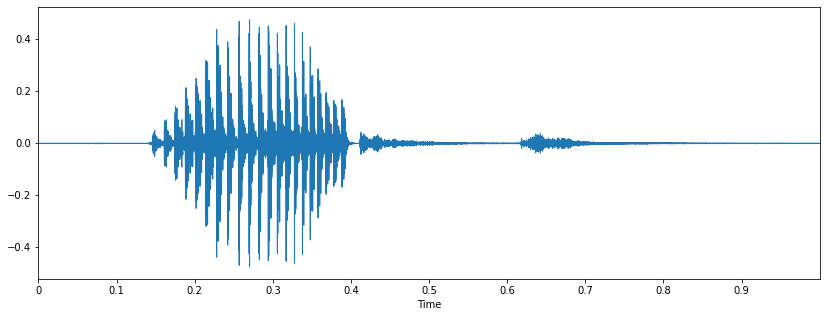

In [38]:
# let's see wave form too

import librosa
import librosa.display
import matplotlib.pyplot as plt
x, sr = librosa.load(sample_data['path'])
print(x, sr)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [39]:
# ToSTFT change shape from (16000) to (1025, 36)
_toSTFT = ToSTFT()
_stft_sample = _toSTFT(_audio_sample)
_stft_sample["stft_shape"]

(1025, 32)

In [40]:
# then change shape from (1025, 36) to (32, 32)
# this is the shape of input 
_toMelSpectrogramFromSTFT = ToMelSpectrogramFromSTFT()
_mel_sample = _toMelSpectrogramFromSTFT(_stft_sample)
_mel_sample["mel_spectrogram"].shape

(32, 32)

In [41]:
# finally we define dataset here

# # train_dataset_dir = "./datasets/speech_commands/train"
# train_dataset_dir = "/disk2/ohashi/pytorch-speech-commands/datasets/speech_commands/train"

# train_dataset = SpeechCommandsDataset(train_dataset_dir,
#                                 Compose([LoadAudio(),
#                                          data_aug_transform,
#                                          add_bg_noise,
#                                          train_feature_transform]))


# specify the percent of entire datasets
use_rate = 0.5
# use_rate = 1.0

train_dataset_dir = "./datasets/speech_commands/train"
# train_dataset = SpeechCommandsDataset(train_dataset_dir,
#                                 Compose([LoadAudio(),
#                                          data_aug_transform,
#                                          add_bg_noise,
#                                          train_feature_transform]), use_rate=use_rate)



In [42]:
# this is a function to create melSpectrogram datasets from audio directly to skip data augumentation
class ToMelSpectrogram(object):
    """Creates the mel spectrogram from an audio. The result is a 32x32 matrix."""

    def __init__(self, n_mels=32):
        self.n_mels = n_mels

    def __call__(self, data):
        samples = data['samples']
        sample_rate = data['sample_rate']
        s = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=self.n_mels)
        data['mel_spectrogram'] = librosa.power_to_db(s, ref=np.max)
        return data

In [43]:
valid_feature_transform = Compose([
    ToMelSpectrogram(n_mels=n_mels), 
    ToTensor('mel_spectrogram', 'input')])

In [44]:
train_dataset = SpeechCommandsDataset(train_dataset_dir,
                                Compose([LoadAudio(),
                                         FixAudioLength(),
                                         valid_feature_transform]), use_rate=use_rate)

In [45]:
# define validation sets

# valid_dataset_dir = "./datasets/speech_commands/valid"
valid_dataset_dir = "/disk2/ohashi/pytorch-speech-commands/datasets/speech_commands/valid"

valid_dataset = SpeechCommandsDataset(valid_dataset_dir,
                                Compose([LoadAudio(),
                                         FixAudioLength(),
                                         valid_feature_transform]))


In [46]:

# get weights for each classes
weights = train_dataset.make_weights_for_balanced_classes()
len(weights)

8144

In [47]:
weights[:4]

array([4.39740821, 4.39740821, 4.39740821, 4.39740821])

In [48]:
# define dataloaders

batch_size = 64
dataload_workers_nums = 4


sampler = WeightedRandomSampler(weights, len(weights))


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, 
                              num_workers=dataload_workers_nums)


valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                              num_workers=dataload_workers_nums)


In [49]:
# aaa = next(iter(train_dataloader))

In [50]:
# now we can define our architecture

In [51]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [52]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [53]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, in_channels=3):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [54]:
def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet34-333f7ec4.pth'))
    return model

In [55]:
# create model 
model = resnet34(num_classes=len(CLASSES), in_channels=1)


In [56]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
device = torch.device("cuda")

# if use_gpu:
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")


In [58]:
# move model to gpu if you use gpu
model = model.to(device)
# model.to(device)

In [59]:
# loss function is normal crossentrophy
criterion = torch.nn.CrossEntropyLoss()

In [60]:

# define optimizer
# adamw seems to be best
learning_rate = 1e-4
weight_decay = 1e-2

# # SGD works
# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-2)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-2)

# AdamW is best
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [61]:
start_timestamp = int(time.time()*1000)
start_epoch = 0
# max_epochs = 70
max_epochs = 18
best_accuracy = 0
best_loss = 1e100
global_step = 0

In [62]:
# probably we don't need schduler for this tutorial

lr_scheduler_patience = 5
lr_scheduler_gamma = 0.1

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=lr_scheduler_patience, 
    factor=lr_scheduler_gamma)


In [63]:
def get_lr():
    return optimizer.param_groups[0]['lr']

In [64]:

full_name = "basic-sgd"

def train(epoch):
    global global_step

    # print("epoch %3d with lr=%.02e" % (epoch, get_lr()))
    phase = 'train'
    
    model.train()  # Set model to training mode

    running_loss = 0.0
    it = 0
    correct = 0
    total = 0

    pbar = tqdm(train_dataloader, unit="audios", unit_scale=train_dataloader.batch_size)
    for batch in pbar:
        
        optimizer.zero_grad()
        
#         inputs_x = batch[0]
        inputs = batch[0]
        targets = batch[1]
        
        # inputs = batch['input']
        # inputs = inputs_x['input']
        inputs = torch.unsqueeze(inputs, 1)
#         targets = batch['target']
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        # forward/backward
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        # statistics
        it += 1
        global_step += 1
    
        # running_loss += loss.data[0]
        running_loss += loss.item()
        
        pred = outputs.max(1, keepdim=True)[1]
        
        # correct += pred.eq(targets.data.view_as(pred)).sum().item()
        correct += pred.eq(targets.view_as(pred)).sum().item()
        total += targets.size(0)
        
        # update the progress bar    
        pbar.set_postfix({
            'loss': "%.05f" % (running_loss / it),
            'acc': "%.02f%%" % (100*correct/total)
        })
    
    accuracy = correct/total
    epoch_loss = running_loss / it
    print('%s/accuracy' % phase, 100*accuracy, epoch)
    print('%s/epoch_loss' % phase, epoch_loss, epoch)
    

In [65]:
def valid(epoch):
    global best_accuracy, best_loss, global_step

    phase = 'valid'
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    it = 0
    correct = 0
    total = 0

    pbar = tqdm(valid_dataloader, unit="audios", unit_scale=valid_dataloader.batch_size)
    for batch in pbar:
        
        # inputs_x = batch[0]
        inputs = batch[0]
        targets = batch[1]
        
        
        # inputs = batch['input']
#         inputs = inputs_x['input']
        inputs = torch.unsqueeze(inputs, 1)
        # targets = batch['target']

        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # statistics
        it += 1
        global_step += 1
        running_loss += loss.item()
        pred = outputs.data.max(1, keepdim=True)[1]

        _correct = pred.eq(targets.view_as(pred)).sum().item()
        correct += _correct

        total += targets.size(0)
        
        # update the progress bar
        pbar.set_postfix({
            'loss': "%.05f" % (running_loss / it),
            'acc': "%.02f%%" % (100*correct/total)
        })
    
    accuracy = correct/total
    epoch_loss = running_loss / it
    
    print('%s/accuracy' % phase, 100*accuracy, epoch)
    print('%s/epoch_loss' % phase, epoch_loss, epoch)
    
    checkpoint = {
        'epoch': epoch,
        'step': global_step,
        'state_dict': model.state_dict(),
        'loss': epoch_loss,
        'accuracy': accuracy,
        'optimizer' : optimizer.state_dict(),
    }

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(checkpoint, 'checkpoints/best-loss-speech-commands-checkpoint-%s.pth' % full_name)
        torch.save(model, '%d-%s-best-loss.pth' % (start_timestamp, full_name))
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(checkpoint, 'checkpoints/best-acc-speech-commands-checkpoint-%s.pth' % full_name)
        torch.save(model, '%d-%s-best-acc.pth' % (start_timestamp, full_name))
    
    torch.save(checkpoint, 'checkpoints/last-speech-commands-checkpoint.pth')
    del checkpoint  # reduce memory

    return epoch_loss

In [66]:

start_epoch = 0

if os.path.isdir('./checkpoints') is False:
    try:
        os.mkdir('./checkpoints')
    except OSError:
        print ("Creation of the directory %s failed" % path)
    

since = time.time()
for epoch in range(start_epoch, max_epochs):

    train(epoch)
    epoch_loss = valid(epoch)

    lr_scheduler.step(metrics=epoch_loss)

    time_elapsed = time.time() - since
    time_str = 'total time elapsed: {:.0f}h {:.0f}m {:.0f}s '.format(time_elapsed // 3600, time_elapsed % 3600 // 60, time_elapsed % 60)
    # print("%s, best accuracy: %.02f%%, best loss %f" % (time_str, 100*best_accuracy, best_loss))
    
print("finished")



  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 71.9425343811395 0
train/epoch_loss 0.6939028587657958 0


100%|██████████| 1152/1152 [00:00<00:00, 1687.20audios/s, loss=0.46859, acc=82.94%]


valid/accuracy 82.93755496921725 0
valid/epoch_loss 0.46859290781948304 0


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 89.71021611001964 1
train/epoch_loss 0.2766589086968452 1


100%|██████████| 1152/1152 [00:00<00:00, 1673.82audios/s, loss=0.35145, acc=86.19%]


valid/accuracy 86.19173262972735 1
valid/epoch_loss 0.3514523050851292 1


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 93.88506876227898 2
train/epoch_loss 0.1775093349860981 2


100%|██████████| 1152/1152 [00:00<00:00, 1697.56audios/s, loss=0.31238, acc=89.09%]


valid/accuracy 89.09410729991205 2
valid/epoch_loss 0.3123849063283867 2


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 95.27259332023576 3
train/epoch_loss 0.12740356803988107 3


100%|██████████| 1152/1152 [00:00<00:00, 1696.22audios/s, loss=0.31827, acc=89.18%]


valid/accuracy 89.18205804749341 3
valid/epoch_loss 0.31826657243072987 3


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 96.2794695481336 4
train/epoch_loss 0.10501195277902298 4


100%|██████████| 1152/1152 [00:00<00:00, 1659.67audios/s, loss=0.30656, acc=90.33%]


valid/accuracy 90.325417766051 4
valid/epoch_loss 0.30655685087872875 4


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 97.12671905697447 5
train/epoch_loss 0.0813232990767574 5


100%|██████████| 1152/1152 [00:00<00:00, 1692.94audios/s, loss=0.27001, acc=91.56%]


valid/accuracy 91.55672823218998 5
valid/epoch_loss 0.2700147374222676 5


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.28094302554028 6
train/epoch_loss 0.05581033421913162 6


100%|██████████| 1152/1152 [00:00<00:00, 1668.18audios/s, loss=0.22746, acc=92.52%]


valid/accuracy 92.52418645558487 6
valid/epoch_loss 0.22745856249497998 6


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.1213163064833 7
train/epoch_loss 0.05988119027460925 7


100%|██████████| 1152/1152 [00:00<00:00, 1647.34audios/s, loss=0.21959, acc=92.96%]


valid/accuracy 92.96394019349165 7
valid/epoch_loss 0.21958968933257791 7


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.53880157170923 8
train/epoch_loss 0.04685405133932363 8


100%|██████████| 1152/1152 [00:00<00:00, 1709.87audios/s, loss=0.24148, acc=92.26%]


valid/accuracy 92.26033421284082 8
valid/epoch_loss 0.2414831237660514 8


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 97.70383104125737 9
train/epoch_loss 0.06122771849913988 9


100%|██████████| 1152/1152 [00:00<00:00, 1741.89audios/s, loss=0.23804, acc=92.70%]


valid/accuracy 92.70008795074757 9
valid/epoch_loss 0.23803803800708717 9


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.30550098231828 10
train/epoch_loss 0.049369756830856204 10


100%|██████████| 1152/1152 [00:00<00:00, 1726.43audios/s, loss=0.22708, acc=93.14%]


valid/accuracy 93.13984168865436 10
valid/epoch_loss 0.22708116906384626 10


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.61247544204322 11
train/epoch_loss 0.042144995473790914 11


100%|██████████| 1152/1152 [00:00<00:00, 1702.25audios/s, loss=0.23848, acc=92.17%]


valid/accuracy 92.17238346525946 11
valid/epoch_loss 0.23847967593206298 11


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.8089390962672 12
train/epoch_loss 0.0359831686510006 12


100%|██████████| 1152/1152 [00:00<00:00, 1676.46audios/s, loss=0.22819, acc=92.70%]


valid/accuracy 92.70008795074757 12
valid/epoch_loss 0.22819143906235695 12


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.87033398821218 13
train/epoch_loss 0.034476944914786145 13


100%|██████████| 1152/1152 [00:00<00:00, 1691.58audios/s, loss=0.20505, acc=93.58%]


valid/accuracy 93.57959542656113 13
valid/epoch_loss 0.2050469977160295 13


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 99.15275049115914 14
train/epoch_loss 0.022735498074325733 14


100%|██████████| 1152/1152 [00:00<00:00, 1675.72audios/s, loss=0.19610, acc=93.58%]


valid/accuracy 93.57959542656113 14
valid/epoch_loss 0.19610442676477963 14


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.87033398821218 15
train/epoch_loss 0.038570907796383835 15


100%|██████████| 1152/1152 [00:00<00:00, 1676.40audios/s, loss=0.19285, acc=93.84%]


valid/accuracy 93.84344766930519 15
valid/epoch_loss 0.19285167960657013 15


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.8089390962672 16
train/epoch_loss 0.03767617132689338 16


100%|██████████| 1152/1152 [00:00<00:00, 1615.18audios/s, loss=0.25732, acc=92.79%]


valid/accuracy 92.78803869832893 16
valid/epoch_loss 0.257320575002167 16


  0%|          | 0/1152 [00:00<?, ?audios/s]

train/accuracy 98.09675834970531 17
train/epoch_loss 0.05883537254703697 17


100%|██████████| 1152/1152 [00:00<00:00, 1690.63audios/s, loss=0.23055, acc=92.88%]


valid/accuracy 92.87598944591029 17
valid/epoch_loss 0.2305483172337214 17
finished


In [67]:
len(train_dataset)

8144

In [68]:
raise Exception("stop")

Exception: stop

In [69]:
# test 

In [70]:
# First, let's see a data sample

import IPython.display
example_path = "ko_voice_right_16000.wav"

IPython.display.Audio(example_path)

In [71]:
# define model again
model2 = resnet34(num_classes=len(CLASSES), in_channels=1)

In [72]:
# load audio 
_load_audio = LoadAudio()
_audio_sample = _load_audio(sample_data)
len(_audio_sample["samples"])

16000

In [73]:
_fixAudioLength = FixAudioLength()

In [74]:
_fixed_sample = _fixAudioLength(_audio_sample)

In [75]:
_processed_input = valid_feature_transform(_fixed_sample)
_processed_input = _processed_input['input']
_processed_input.shape

torch.Size([32, 32])

In [76]:
_processed_input = _processed_input[None]
_processed_input = _processed_input[None]
_processed_input.shape

torch.Size([1, 1, 32, 32])

In [77]:
# load saved weights
weight_path2 = "./checkpoints/best-acc-speech-commands-checkpoint-basic1.pth"
# weight_path2 = "./checkpoints/best-acc-speech-commands-checkpoint-speech_command_with_fl.pth"
# weight_path2 = "./checkpoints/last-speech-commands-checkpoint.pth"

state2 = torch.load(
    weight_path2, 
    map_location=torch.device("cpu"))

_ = model2.load_state_dict(state2['state_dict'])

In [78]:
# get prediction
_ = model2.eval()
_eval_output = model2(_processed_input)
_eval_pred = _eval_output.max(1, keepdim=True)[1]
_eval_pred



tensor([[5]])

In [79]:
CLASSES

['unknown', 'silence', 'yes', 'no', 'left', 'right']